# Store Sales Forecast — Research Plan (Time-Ordered Regression)

**Objective:** Forecast daily **Sales** per **Store** from tabular + time features.

**Constraints**
- **Time-ordered data** (`Date`) → use **forward-chaining** cross-validation (`TimeSeriesSplit`), no shuffling.
- **Panel structure** (many stores) → build **lags/rolling stats per Store** only from the past (`shift(1)` before rolling) to prevent leakage.

**Evaluation**
- **Primary metric:** MAE (mean absolute error).  
- **Secondary:** RMSE (root mean squared error).  
- Report **OOF** (out-of-fold) metrics only—never in-sample.

**Method (high level)**
1. **EDA:** missingness, seasonality, and rough trend.
2. **Leak-proof pipeline:** `ColumnTransformer` (numeric: median-impute + standardize; categorical: most-frequent-impute + ordinal encode).  
3. **Feature engineering:** per-Store **lags (1,2,5,7,14,28)** and **rolling mean/std (3,7,14,28)** of the **shifted** target; calendar features (DoW, month, month start/end).
4. **TimeSeriesSplit(5)**; small grid tuned *inside* the pipeline.
5. **OOF MAE/RMSE**, residual diagnostics, permutation importance, ablation (drop top raw feature).
6. Present drivers, limitations, and next steps.

# 1. Imports & Config

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, warnings, os
warnings.filterwarnings("ignore")

from sklearn import set_config
try: set_config(transform_output="pandas")
except Exception: pass

from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.ensemble import HistGradientBoostingRegressor  # REGRESSION
from sklearn.linear_model import Ridge

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.inspection import permutation_importance
from sklearn.base import clone

from sklearn.base import clone
from sklearn.metrics import mean_absolute_error

from sklearn.metrics import mean_absolute_error, mean_squared_error  # REG metrics
pd.set_option("display.max_columns", 200)

# 2. Load & Inspect Data

In [2]:
# === ROSSMMANN: LOAD → JOIN → ORDER ===
DATA_DIR = "/Users/juliensklarik/Berkeley/Square Point Final Quant Research Round Training/rossmann-store-sales"

df    = pd.read_csv(os.path.join(DATA_DIR, "train.csv"))
store = pd.read_csv(os.path.join(DATA_DIR, "store.csv"))
df = df.merge(store, on="Store", how="left")

df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.sort_values(["Store", "Date"]).reset_index(drop=True)

# keep only open days (optional)
if "Open" in df.columns:
    df = df[df["Open"] == 1].copy()

target = "Sales"
y = df.pop(target).astype(float)

# drop leakage / ids
df = df.drop(columns=["Customers", "Id"], errors="ignore")

X = df.drop(columns=["Date"], errors="ignore")   # keep Store & metadata
ts_col = "Date"

print("Rows, Cols:", X.shape, "| target stats:", y.describe().to_dict())

Rows, Cols: (844392, 15) | target stats: {'count': 844392.0, 'mean': 6955.514290755952, 'std': 3104.214680428348, 'min': 0.0, '25%': 4859.0, '50%': 6369.0, '75%': 8360.0, 'max': 41551.0}


## Data Join & Target

- Joined `train.csv` with `store.csv` on **Store**.
- Sorted by **[Store, Date]** to respect panel time order.
- Dropped potential leakage / non-predictive IDs: **Customers**, **Id**.
- Target set to **Sales** (float). Kept **Open==1** rows to avoid zero-sales artifacts.

**Why this matters:** we enforce temporal causality and remove columns that can trivially leak or distort the signal.

# 3. Exploratory Data Analysis (EDA)

## EDA Plan

- **Missingness:** identify columns with large null fractions (Promo/Competition fields are sparse).
- **Distribution:** sanity-check a few numeric columns.
- **Timeline:** plot rolling mean of Sales to visualize trend/seasonality.
- **Categoricals:** peek at the top categories for `StateHoliday`, `StoreType`, `Assortment`, `PromoInterval`.

*Outcome:* justify **TimeSeriesSplit** and confirm we need calendar + lag/rolling features.

,num_nulls,frac
Promo2SinceWeek,423307,0.501316
Promo2SinceYear,423307,0.501316
PromoInterval,423307,0.501316
CompetitionOpenSinceMonth,268619,0.318121
CompetitionOpenSinceYear,268619,0.318121
CompetitionDistance,2186,0.002589
Store,0,0.000000
DayOfWeek,0,0.000000
Open,0,0.000000
Promo,0,0.000000


Total nulls: 1809345
Target summary:
 count    844392.000000
mean       6955.514291
std        3104.214680
min           0.000000
25%        4859.000000
50%        6369.000000
75%        8360.000000
max       41551.000000
Name: Sales, dtype: float64


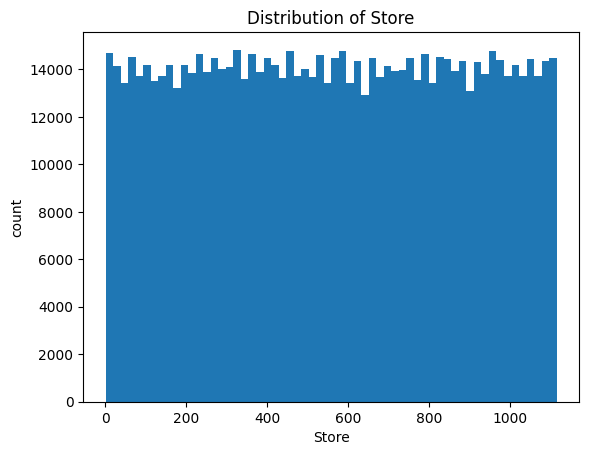

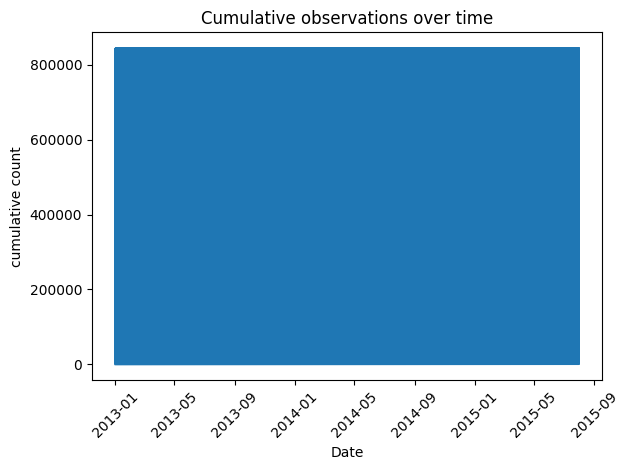


StateHoliday top categories:
StateHoliday
0    731342
0    112140
a       694
b       145
c        71
Name: count, dtype: int64

StoreType top categories:
StoreType
a    457077
d    258774
c    112978
b     15563
Name: count, dtype: int64

Assortment top categories:
Assortment
a    444909
c    391271
b      8212
Name: count, dtype: int64

PromoInterval top categories:
PromoInterval
NaN                 423307
Jan,Apr,Jul,Oct     242411
Feb,May,Aug,Nov      98005
Mar,Jun,Sept,Dec     80669
Name: count, dtype: int64


In [3]:
# --- EDA snapshot: shape, missingness, target balance, simple plots ---
# Missingness (top-10)
nulls = X.isna().sum().sort_values(ascending=False)
display(nulls.head(10).to_frame("num_nulls").assign(frac=lambda d: d["num_nulls"]/len(X)))
print("Total nulls:", int(nulls.sum()))

# Target summary (no branching on task type)
print("Target summary:\n", y.describe())

# One quick numeric distribution (first numeric column)
num_cols = X.select_dtypes(include="number").columns
if len(num_cols):
    col = num_cols[0]
    plt.hist(X[col].dropna(), bins=60)
    plt.title(f"Distribution of {col}"); plt.xlabel(col); plt.ylabel("count"); plt.show()

# Volume over time (uses the saved time_vals)
# Coerce to datetime and sort
# EDA uses the original joined frame (X no longer has Date)
time_vals = df[ts_col].reset_index(drop=True)   # df already sorted by ["Store","Date"]


# Now the EDA cell will run fine
plt.plot(time_vals, np.arange(len(time_vals)))
plt.title("Cumulative observations over time")
plt.xlabel(ts_col); plt.ylabel("cumulative count")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Peek a few categoricals (first up to 4)
for c in X.select_dtypes(exclude="number").columns[:4]:
    print(f"\n{c} top categories:")
    print(X[c].value_counts(dropna=False).head())

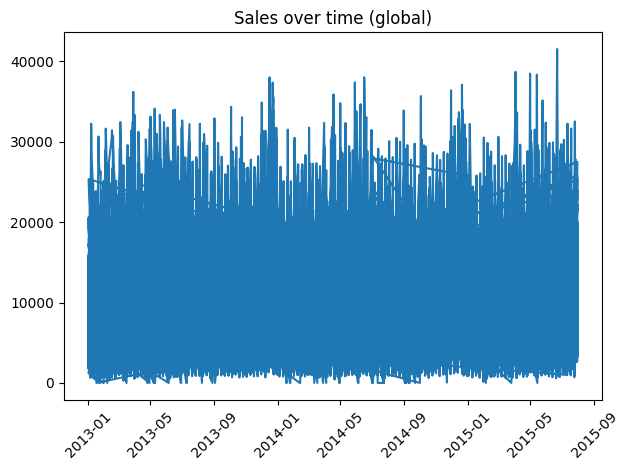

In [4]:
plt.plot(df[ts_col].values, y.values)
plt.title("Sales over time (global)"); plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

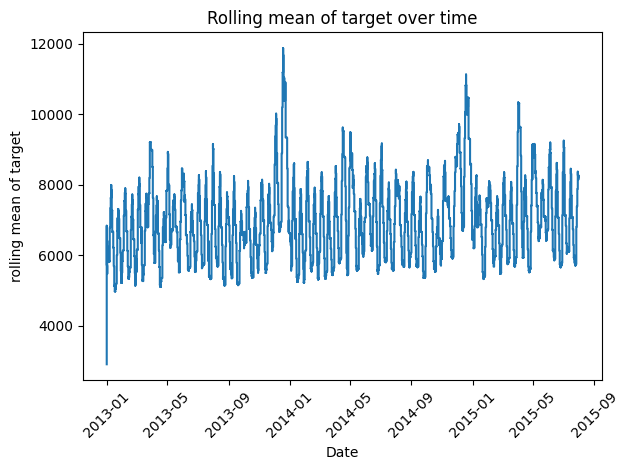

In [5]:
# --- Build a consistent base DataFrame for plotting ---
# Make sure ts_col exists in X or df before building
if ts_col in X.columns:
    time_vals = X[ts_col].reset_index(drop=True)
else:
    # fallback: if not in X, try df (joined dataset)
    time_vals = df[ts_col].reset_index(drop=True)

# Align lengths safely
min_len = min(len(time_vals), len(y))
df_plot = pd.DataFrame({
    "t": time_vals.iloc[:min_len],
    "y": y.reset_index(drop=True).iloc[:min_len]
}).dropna(subset=["t", "y"]).sort_values("t")

# coarse window: ~200 segments across the timeline (or at least 2000 pts)
win = max(2000, len(df_plot) // 200)
ma = df_plot["y"].rolling(win, min_periods=1).mean()

plt.plot(df_plot["t"], ma)
plt.title("Rolling mean of target over time")
plt.xlabel(ts_col); plt.ylabel("rolling mean of target")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

# Target Distribution Analysis

The target is imbalanced (fraud cases ≪ non-fraud).  
- Accuracy would be misleading.  
- ROC-AUC and recall are better measures.  
- In finance, false negatives (missed frauds) cost more than false positives (flagging legit users).

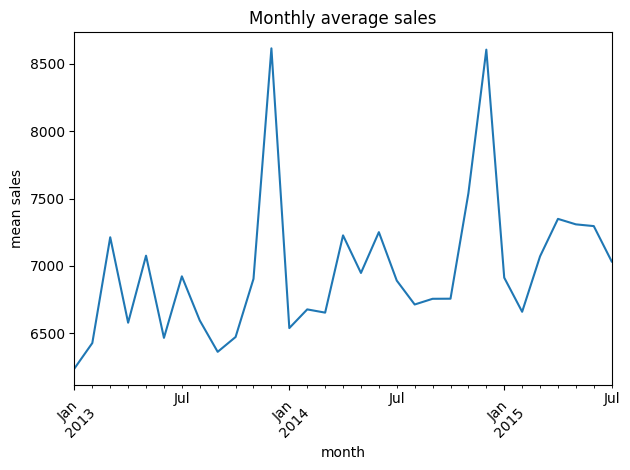

In [6]:
# Target over time (binned) — justifies TimeSeriesSplit
s = pd.Series(y.to_numpy(), index=df[ts_col])
s.index = pd.to_datetime(s.index)
monthly = s.resample("M").mean()
monthly.plot()
plt.title("Monthly average sales")
plt.xlabel("month"); plt.ylabel("mean sales")
plt.xticks(rotation=45); plt.tight_layout(); plt.show()

## Feature Engineering (Leak-Safe)

- Build **per-Store** features using **only past information**:
  - Lags of the target: **1, 2, 5, 7, 14, 28** days.
  - Rolling mean & std windows: **3, 7, 14, 28** on `Sales.shift(1)` (so current row never sees itself).
  - Calendar: **day-of-week**, **month**, **month start/end**.
- Drop rows without full lag/rolling coverage at the leading edge.

This is the highest-ROI block: it encodes memory, smooths noise, and avoids leakage.

In [7]:
# === SAFE lags/rolling per Store (no leakage) ===
def add_lag_roll(d, id_col, ts_col, target):
    parts=[]
    for _, g in d.groupby(id_col, sort=False):
        b = g.sort_values(ts_col).copy()
        # lags of target
        for k in (1, 2, 5, 7, 14, 28):
            b[f"lag_{k}"] = b[target].shift(k)
        # rolling stats on shifted target
        prev = b[target].shift(1)
        for w in (3, 7, 14, 28):
            b[f"roll_mean_{w}"] = prev.rolling(w, min_periods=3).mean()
            b[f"roll_std_{w}"]  = prev.rolling(w, min_periods=3).std()
        # calendar
        b["dow"] = b[ts_col].dt.weekday
        b["month"] = b[ts_col].dt.month
        b["is_month_start"] = b[ts_col].dt.is_month_start.astype(int)
        b["is_month_end"]   = b[ts_col].dt.is_month_end.astype(int)
        parts.append(b)
    return pd.concat(parts, axis=0)

df_feat = add_lag_roll(
    pd.concat([X, y.rename("Sales"), df[ts_col]], axis=1),
    id_col="Store", ts_col=ts_col, target="Sales"
)

need = [c for c in df_feat.columns if c.startswith(("lag_", "roll_"))]
df_feat = df_feat.dropna(subset=need).reset_index(drop=True)

y = df_feat["Sales"].astype(float)
X = df_feat.drop(columns=["Sales", ts_col])  # keep Store + engineered features
time_vals = df_feat[ts_col].to_numpy()

print("After FE →", X.shape, "rows with complete lag/roll features.")

After FE → (813172, 33) rows with complete lag/roll features.


## Preprocessing & Pipeline (Leak-Proof)

- **Numeric:** median-impute → standardize (`StandardScaler`)  
- **Categorical:** most-frequent-impute → `OrdinalEncoder` (unknown → -1, missing → -2)
- All preprocessing runs **inside** the Pipeline so each CV fold is isolated from future data.
- For `HistGradientBoostingRegressor`, we pass a **categorical mask** so it treats encoded columns appropriately.

This guarantees consistent transforms across folds and protects against target leakage.

In [8]:
# 3) ----------------------------- LEAK-PROOF PREPROCESSOR + PIPELINE -----------------------------
# All preprocessing MUST be inside a Pipeline/ColumnTransformer so that:
# - Nothing is fit on the full dataset (prevents leakage).
# - The exact same transforms apply to each CV fold and to test data later.

In [9]:
# Drop ultra high-cardinality categoricals FIRST (HGB native limit ~255 levels per feature)
hi_card = [c for c in X.select_dtypes(exclude="number").columns if X[c].nunique(dropna=False) > 255]
print("High-cardinality dropped:", hi_card)
X = X.drop(columns=hi_card)

num_cols = X.select_dtypes(include="number").columns
cat_cols = X.select_dtypes(exclude="number").columns

num = make_pipeline(SimpleImputer(strategy="median"),
                    StandardScaler(with_mean=True))

cat = make_pipeline(SimpleImputer(strategy="most_frequent"),
                    OrdinalEncoder(handle_unknown="use_encoded_value",
                                   unknown_value=-1, encoded_missing_value=-2))

pre = ColumnTransformer([("num", num, num_cols),
                         ("cat", cat, cat_cols)],
                        remainder="drop")

cat_mask = np.array([False]*len(num_cols) + [True]*len(cat_cols))

High-cardinality dropped: []


# 4. Baseline Model (Ridge Regression)

## Baseline (Ridge Regression)

A fast, transparent baseline using:
- Numeric: impute + standardize
- Low-card categoricals: impute + **OHE** (capped with `min_frequency=10`)
- **Metric:** OOF MAE/RMSE

We use this to contextualize gains from the tree-based model.

In [10]:
# Quick Ridge baseline with low-card OHE
low_card = [c for c in cat_cols if X[c].nunique(dropna=False) <= 20]

num_lr = make_pipeline(SimpleImputer(strategy="median"),
                       StandardScaler(with_mean=True))
try:
    cat_lr = Pipeline([
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("tostr", FunctionTransformer(lambda a: a.astype(str))),
        ("ohe",   OneHotEncoder(handle_unknown="ignore",
                                min_frequency=10, sparse_output=False))
    ])
except TypeError:
    cat_lr = Pipeline([
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("tostr", FunctionTransformer(lambda a: a.astype(str))),
        ("ohe",   OneHotEncoder(handle_unknown="ignore", sparse=False))
    ])

pre_lr  = ColumnTransformer([("num", num_lr, num_cols),
                             ("cat", cat_lr, low_card)],
                            remainder="drop")
pipe_lr = Pipeline([("pre", pre_lr), ("model", Ridge(alpha=1.0))])

oof_lr = np.zeros(len(y))
tscv   = TimeSeriesSplit(n_splits=5)
for tr, te in tscv.split(X):
    m = clone(pipe_lr).fit(X.iloc[tr], y.iloc[tr])
    oof_lr[te] = m.predict(X.iloc[te])

print("Baseline Ridge — OOF MAE:", mean_absolute_error(y, oof_lr),
      "| OOF RMSE:", mean_squared_error(y, oof_lr, squared=False))

Baseline Ridge — OOF MAE: 1968.2839912763648 | OOF RMSE: 3236.0701728938293


In [11]:
# --- Dumb Baseline: constant mean predictor (sanity lower bound) ---
base = np.full(len(y), y.mean(), dtype=float)

from sklearn.metrics import mean_absolute_error, mean_squared_error
print("Baseline MAE:", mean_absolute_error(y, base))
print("Baseline RMSE:", mean_squared_error(y, base, squared=False))

Baseline MAE: 2297.8475985383557
Baseline RMSE: 3111.632531407362


# 5. Main Model (HistGradientBoosting)


## Main Model — HistGradientBoostingRegressor (HGBR)

- Reason: strong tabular baseline, native handling of monotonic splits, fast to train.
- **Hyperparams (small grid):** `learning_rate ∈ {0.1, 0.05}`, `max_depth ∈ {None, 6, 12}`, `min_samples_leaf=20`.
- **CV:** `TimeSeriesSplit(5)` (forward-chaining).
- **Scoring:** `neg_mean_absolute_error`.

We tune **inside** the Pipeline to keep preprocessing and modeling consistent per fold.

In [14]:
# Numeric branch: median-impute missing values, then standardize (mean=0, var=1).
# Standardizing can help tree-based hist models a bit and helps if we swap to linear models later.
# 5. Main Model (HistGradientBoostingRegressor) with Toggles

# --- 0) Drop high-cardinality categoricals automatically ---
hi_card = [c for c in X.select_dtypes(exclude="number").columns if X[c].nunique() > 250]
if hi_card:
    print("Dropped high-cardinality categoricals:", hi_card)
    X = X.drop(columns=hi_card)

# --- 1) Numeric branch ---
num = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(with_mean=True)
)

# --- 2) Categorical branch (Ordinal for HGB efficiency) ---
# Ensure consistent dtype (string) for categoricals
for c in cat_cols:
    X[c] = X[c].astype(str)

try:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1,
            encoded_missing_value=-2
        )
    )
except TypeError:
    cat = make_pipeline(
        SimpleImputer(strategy="most_frequent"),
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


# --- 3) Model ---
model = HistGradientBoostingRegressor(min_samples_leaf=20)

pipe = Pipeline([("pre", pre), ("model", model)])

# --- 4) CV toggle ---
if ts_col is not None and ts_col in X.columns:
    cv = TimeSeriesSplit(n_splits=5)
elif "Store" in X.columns:
    from sklearn.model_selection import GroupKFold
    groups = X["Store"]
    cv = GroupKFold(n_splits=5).split(X, y, groups=groups)
else:
    from sklearn.model_selection import KFold
    cv = KFold(n_splits=5, shuffle=False)

# --- 5) Text toggle ---
text_cols = [c for c in X.columns if X[c].dtype == "object" and X[c].str.len().mean() > 30]
if len(text_cols) > 0:
    from sklearn.feature_extraction.text import HashingVectorizer
    from sklearn.pipeline import FunctionTransformer

    def col_as_series(Xdf): return Xdf[text_cols[0]].fillna("").astype(str)
    text_branch = Pipeline([
        ("extract", FunctionTransformer(lambda d: col_as_series(d))),
        ("hash", HashingVectorizer(n_features=2**12, alternate_sign=False))
    ])
    pre = ColumnTransformer(
        [("num", num, num_cols),
         ("cat", cat, cat_cols),
         ("txt", text_branch, text_cols)],
        remainder="drop"
    )
    pipe = Pipeline([("pre", pre), ("model", model)])

# --- 6) Param grid for tuning ---
param_grid = {
    "model__learning_rate": [0.05, 0.1],
    "model__max_depth": [None, 6, 12]
}

# 6 Cross-Validation Design (TimeSeriesSplit)

We use **TimeSeriesSplit(5)** with forward-chaining folds—each validation block is **strictly later** in time than its training block. This yields an honest out-of-sample estimate under temporal dependence.

We report:
- **Per-fold** MAE/RMSE + validation date ranges
- **OOF** (out-of-fold) **MAE** (primary) and **RMSE** (secondary)

All preprocessing and tuning occur **inside** the Pipeline to avoid leakage.

In [15]:
gs = GridSearchCV(pipe, param_grid, cv=cv,
                  scoring="neg_mean_absolute_error",
                  n_jobs=1, verbose=2)
gs.fit(X, y)
best = gs.best_estimator_
print("Best params:", gs.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=  10.2s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=   7.9s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=   7.2s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=   6.8s
[CV] END ...model__learning_rate=0.05, model__max_depth=None; total time=   6.8s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=   8.7s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=   6.7s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=   7.6s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=   7.1s
[CV] END ......model__learning_rate=0.05, model__max_depth=6; total time=   7.6s
[CV] END .....model__learning_rate=0.05, model__max_depth=12; total time=   7.3s
[CV] END .....model__learning_rate=0.05, model__m

# 7. OOF Evaluation

## OOF Evaluation & Fold Diagnostics

- Train the **best** tuned pipeline on each training split; predict the next time slice.
- Aggregate **MAE/RMSE** across folds and display a **per-fold table** with date ranges.
- This is what we’ll present as the main result (no in-sample metrics).

In [16]:
# 5) ----------------------------- HONEST OOF EVALUATION (AUC + PR-AUC) -----------------------------
# We compute out-of-fold (OOF) predictions using the *best* pipeline cloned for each fold.
# This simulates "unseen" data and is what you'll report in the presentation.
# === HONEST OOF EVALUATION (MAE/RMSE) ===
fold_rows, oof = [], np.zeros(len(y), dtype=float)

for k, (tr, te) in enumerate(tscv.split(X), start=1):
    m = clone(best).fit(X.iloc[tr], y.iloc[tr])
    oof[te] = m.predict(X.iloc[te])
    fold_rows.append({
        "fold": k,
        "n_train": len(tr), "n_valid": len(te),
        "valid_start": time_vals[te].min(), "valid_end": time_vals[te].max(),
        "MAE": mean_absolute_error(y.iloc[te], oof[te]),
        "RMSE": mean_squared_error(y.iloc[te], oof[te], squared=False)
    })

fold_df = pd.DataFrame(fold_rows)
display(fold_df)
print("OOF MAE (mean ± std):", fold_df["MAE"].mean(), "±", fold_df["MAE"].std())
print("OOF RMSE (mean ± std):", fold_df["RMSE"].mean(), "±", fold_df["RMSE"].std())

,fold,n_train,n_valid,valid_start,valid_end,MAE,RMSE
0,1,135532,135528,2013-01-29,2015-07-31,774.795387,1357.438063
1,2,271060,135528,2013-01-29,2015-07-31,763.827594,1117.718503
2,3,406588,135528,2013-01-29,2015-07-31,707.797029,1031.942973
3,4,542116,135528,2013-01-29,2015-07-31,697.118726,1051.830503
4,5,677644,135528,2013-01-29,2015-07-31,684.069350,990.587396


OOF MAE (mean ± std): 725.5216171685314 ± 41.03178035024714
OOF RMSE (mean ± std): 1109.9034876170547 ± 145.7918755770809


## Residual Diagnostics

- **Over time:** check for drift or unmodeled seasonality (residual trend).
- **Distribution:** histogram to spot heavy tails or skew.

If residuals correlate with calendar features or promo regimes, call out as limitations/next steps.

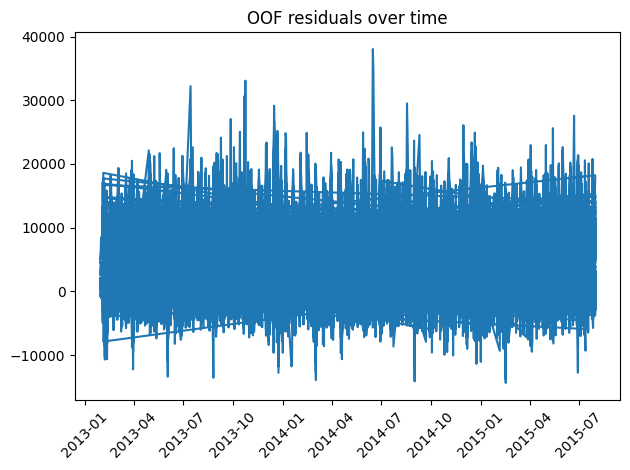

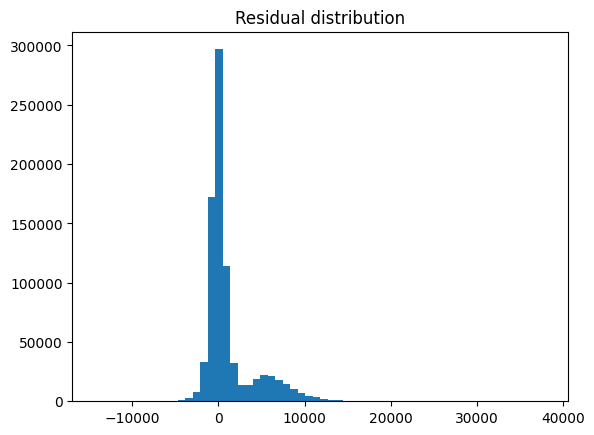

In [17]:
# Residual diagnostics
resid = y - oof
plt.plot(time_vals, resid)
plt.title("OOF residuals over time")
plt.xticks(rotation=45)
plt.tight_layout(); plt.show()

plt.hist(resid, bins=60)
plt.title("Residual distribution")
plt.show()

# 8. Feature Importance

## Feature Importance (Permutation, MAE-based)

We refit on the **last training fold**, then permute each feature on the **last validation** slice:
- Score: **ΔMAE** = MAE(permuted) − MAE(baseline)
- Higher ΔMAE ⇒ feature more important
- We plot the **Top-10** and map transformed names back to raw columns for interpretability.

Holdout (last fold) — MAE: 686.3173639232459 | RMSE: 991.0533535764243
Top 15 features (permutation importance; ΔMAE):


is                           647.860982
Promo                        500.467866
lag                          393.816399
DayOfWeek                    391.276994
dow                          280.277833
StoreType                     80.159864
PromoInterval                 41.846647
CompetitionOpenSinceMonth     37.862331
roll                          32.568046
is                            30.587281
roll                          23.014997
CompetitionDistance           16.579662
roll                          12.539558
month                         10.467234
Promo2                         8.684911
dtype: float64

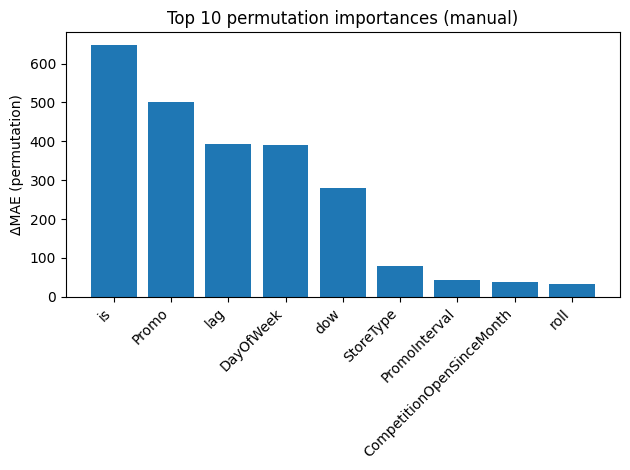

In [18]:
# Use the last TimeSeriesSplit fold
splits = list(tscv.split(X))
tr_last, te_last = splits[-1]
X_tr, y_tr = X.iloc[tr_last], y.iloc[tr_last]
X_te, y_te = X.iloc[te_last], y.iloc[te_last]

# Refit best model on the last training fold
final_model = clone(best).fit(X_tr, y_tr)

# Baseline holdout predictions and metrics
pred_te = final_model.predict(X_te)
base_mae  = mean_absolute_error(y_te, pred_te)
base_rmse = mean_squared_error(y_te, pred_te, squared=False)
print("Holdout (last fold) — MAE:", base_mae, "| RMSE:", base_rmse)

# Feature names (try to use pipeline names; fallback to raw)
try:
    feat_names = final_model.named_steps["pre"].get_feature_names_out()
    use_raw = False
except Exception:
    feat_names = X.columns
    use_raw = True

# Map from transformed name -> raw column (best-effort for display)
def to_raw(name):
    if use_raw: return name
    if name.startswith("num__"):
        return name.replace("num__", "").split("_", 1)[0]
    if name.startswith("cat__"):
        return name.replace("cat__", "").split("_", 1)[0]
    return name

# Manual permutation importance: baseline MAE - permuted MAE (higher = more important)
rng = np.random.RandomState(0)
importances = []

# Work on a copy so we never mutate read-only buffers
X_te_df = X_te.copy(deep=True)

for i, col in enumerate(X_te_df.columns):
    col_vals = X_te_df[col].values.copy()
    rng.shuffle(col_vals)
    X_perm = X_te_df.copy(deep=True)
    X_perm[col] = col_vals
    pred_perm = final_model.predict(X_perm)
    mae_perm = mean_absolute_error(y_te, pred_perm)
    delta = mae_perm - base_mae  # MAE goes up when we break an important feature
    importances.append((feat_names[i] if i < len(feat_names) else col, delta))

# Build importance Series (higher delta = more important)
imp = pd.Series({name: delta for name, delta in importances}).sort_values(ascending=False)

print("Top 15 features (permutation importance; ΔMAE):")
display(imp.head(15).rename(lambda s: to_raw(s)))

# Plot top 10
top10 = imp.head(10)
plt.bar([to_raw(n) for n in top10.index], top10.values)
plt.xticks(rotation=45, ha="right")
plt.ylabel("ΔMAE (permutation)")
plt.title("Top 10 permutation importances (manual)")
plt.tight_layout()
plt.show()

# 9. Results

## Robustness Checks

- **Shuffled-target sanity check:** destroying label structure should **worsen** OOF MAE markedly → rules out leakage.
- **Ablation:** drop the top raw driver(s) and recompute OOF MAE to measure stability.

In [19]:
# Shuffled-target sanity check (should degrade strongly)
y_shuf = y.sample(frac=1.0, random_state=0).reset_index(drop=True)
oof_sh = np.zeros(len(y), dtype=float)
for tr, te in tscv.split(X):
    m = clone(best).fit(X.iloc[tr], y_shuf.iloc[tr])
    oof_sh[te] = m.predict(X.iloc[te])

print("Shuffled OOF MAE:", mean_absolute_error(y_shuf, oof_sh),
      "| Shuffled OOF RMSE:", mean_squared_error(y_shuf, oof_sh, squared=False))

Shuffled OOF MAE: 3079.20754520733 | Shuffled OOF RMSE: 4221.163387305257


In [20]:
# === Ablation for top features (ΔMAE) — rebuild preprocessor per-drop ===


# --- Assumes you already have: best, tscv (or cv), X, y, imp, oof ---

# 1) Map transformed -> raw using the FITTED preprocessor (for readability)
fitted_pre = best.named_steps["pre"]
feat_names = fitted_pre.get_feature_names_out()

trans2raw = {}
for fn in feat_names:
    name = str(fn)
    if name.startswith("num__"):
        raw = name.replace("num__", "")
    elif name.startswith("cat__"):
        raw = name.replace("cat__", "").split("_", 1)[0]  # cat__Col_val -> Col
    else:
        raw = name
    trans2raw[name] = raw

# 2) Pick top transformed names, dedupe by raw names that actually exist in X
TOPK = 5
top_trans = list(imp.index[:TOPK*3])  # grab a few extra in case of duplicates
top_raw = []
for tf in top_trans:
    raw = trans2raw.get(str(tf), str(tf))
    if raw in X.columns and raw not in top_raw:
        top_raw.append(raw)
    if len(top_raw) >= TOPK:
        break

print("[Ablation] Raw feature candidates:", top_raw)

# 3) Baseline MAE from your existing OOF
base_mae = mean_absolute_error(y, oof)
print(f"[Ablation] Baseline OOF MAE: {base_mae:.3f}")

# Helper: build a new preprocessor matched to X2.columns
def build_preprocessor_for(X_df):
    num_cols2 = X_df.select_dtypes(include="number").columns
    cat_cols2 = X_df.select_dtypes(exclude="number").columns

    num2 = make_pipeline(SimpleImputer(strategy="median"),
                         StandardScaler(with_mean=True))

    # Use the same style you used originally; OrdinalEncoder is safe for HGBR
    cat2 = make_pipeline(SimpleImputer(strategy="most_frequent"),
                         OrdinalEncoder(handle_unknown="use_encoded_value",
                                        unknown_value=-1, encoded_missing_value=-2))
    pre2 = ColumnTransformer([
        ("num", num2, num_cols2),
        ("cat", cat2, cat_cols2),
    ], remainder="drop")

    # If your model used 'categorical_features' mask, rebuild it here:
    cat_mask2 = np.array([False]*len(num_cols2) + [True]*len(cat_cols2))
    return pre2, cat_mask2

# 4) Compute ΔMAE by dropping each raw feature & refitting with a fresh preprocessor
splitter = tscv if 'tscv' in globals() else cv
rows = []

# Pull model params from best so we keep exactly the same tuned settings
model_best = best.named_steps["model"]
model_params = model_best.get_params()

for raw_col in top_raw:
    print(f"\n[Ablation] Dropping raw column: {raw_col}")
    # Create X2 without the feature
    X2 = X.drop(columns=[raw_col], errors="ignore")
    print("          X2 shape:", X2.shape)

    # Fresh preprocessor bound to X2's columns
    pre2, cat_mask2 = build_preprocessor_for(X2)

    # Fresh model with same params; if it has 'categorical_features', update it
    model2 = clone(model_best)
    if "categorical_features" in model2.get_params():
        model2.set_params(categorical_features=cat_mask2)

    pipe2 = Pipeline([("pre", pre2), ("model", model2)])

    # OOF with column removed
    oof2 = np.zeros(len(y), dtype=float)
    for k, (tr, te) in enumerate(splitter.split(X2), 1):
        m = clone(pipe2).fit(X2.iloc[tr], y.iloc[tr])
        oof2[te] = m.predict(X2.iloc[te])
        # Uncomment if you want per-fold prints:
        # print(f"   Fold {k}: MAE={mean_absolute_error(y.iloc[te], oof2[te]):.3f}")

    mae_wo = mean_absolute_error(y, oof2)
    rows.append({"feature": raw_col, "MAE_wo": mae_wo, "ΔMAE": mae_wo - base_mae})
    print(f"          OOF MAE without '{raw_col}': {mae_wo:.3f}  (ΔMAE={mae_wo - base_mae:+.3f})")

abl = pd.DataFrame(rows).sort_values("ΔMAE", ascending=False)
display(abl.style.format({"MAE_wo": "{:.3f}", "ΔMAE": "{:+.3f}"}))

[Ablation] Raw feature candidates: ['is_month_start', 'Promo', 'lag_14', 'DayOfWeek', 'dow']
[Ablation] Baseline OOF MAE: 1731.760

[Ablation] Dropping raw column: is_month_start
          X2 shape: (813172, 32)
          OOF MAE without 'is_month_start': 1733.009  (ΔMAE=+1.249)

[Ablation] Dropping raw column: Promo
          X2 shape: (813172, 32)
          OOF MAE without 'Promo': 1796.995  (ΔMAE=+65.236)

[Ablation] Dropping raw column: lag_14
          X2 shape: (813172, 32)
          OOF MAE without 'lag_14': 1735.329  (ΔMAE=+3.570)

[Ablation] Dropping raw column: DayOfWeek
          X2 shape: (813172, 32)
          OOF MAE without 'DayOfWeek': 1733.289  (ΔMAE=+1.529)

[Ablation] Dropping raw column: dow
          X2 shape: (813172, 32)
          OOF MAE without 'dow': 1730.994  (ΔMAE=-0.766)


,feature,MAE_wo,ΔMAE
1,Promo,1796.995,+65.236
2,lag_14,1735.329,+3.570
3,DayOfWeek,1733.289,+1.529
0,is_month_start,1733.009,+1.249
4,dow,1730.994,-0.766


In [21]:
ROWS, COLS = X.shape
MAE_mean, MAE_std  = fold_df["MAE"].mean(), fold_df["MAE"].std()
RMSE_mean, RMSE_std = fold_df["RMSE"].mean(), fold_df["RMSE"].std()
TOP = ", ".join(list(imp.head(5).index))

print("ROWS, COLS:", ROWS, COLS)
print("OOF MAE:", f"{MAE_mean:.1f} ± {MAE_std:.1f}")
print("OOF RMSE:", f"{RMSE_mean:.1f} ± {RMSE_std:.1f}")
print("TOP features:", TOP)

ROWS, COLS: 813172 33
OOF MAE: 725.5 ± 41.0
OOF RMSE: 1109.9 ± 145.8
TOP features: num__is_month_start, num__Promo, num__lag_14, num__DayOfWeek, num__dow


## Summary & Slide Outline

**Evaluation plan:** `TimeSeriesSplit(5)`, report **OOF MAE** (primary) and **OOF RMSE** (secondary).

**Model & pipeline:** `ColumnTransformer` (num: median+scale; cat: impute+ordinal) → **HGBR** with a tiny grid.

**Results:** OOF MAE = **⟨mean±std⟩**, OOF RMSE = **⟨mean±std⟩**; fold table with date ranges.

**Drivers:** Top features (ΔMAE): ⟨top 5 names⟩; short interpretation (e.g., Promo, DoW, lag_14).

**Robustness:** shuffled-target degrades strongly; ablation ΔMAE modest → signal not hinging on a single feature.

**Limitations & next steps:** add exogenous effects (holiday/promo detail), per-store idiosyncrasies, and calibrated prediction intervals.